# Core Sensitivity Testing with results_df

## Overview

This notebook demonstrates **processor core sensitivity analysis** for HEC-RAS 2D unsteady flow models. Understanding how computational performance scales with available CPU cores is essential for:

- **Resource Planning**: Determining optimal hardware for production runs
- **Cost-Benefit Analysis**: Evaluating whether additional cores justify computation time savings
- **Workflow Optimization**: Identifying diminishing returns for parallelization

### What This Notebook Does

1. Extracts a 2D example project (BaldEagleCrkMulti2D)
2. Runs the same plan with varying numbers of processor cores (1 to `NUM_WORKERS`)
3. **Uses `ras.results_df` for accurate HDF-based runtime extraction** (v0.88.4+)
4. Verifies all runs completed successfully with consistent results
5. Visualizes performance scaling, speedup factors, and time breakdown

### Key Feature: Using results_df

This notebook uses the `ras.results_df` DataFrame for runtime extraction instead of wall-clock timing:

- `runtime_complete_process_hours` - Total HEC-RAS execution time (from HDF)
- `runtime_unsteady_compute_hours` - Unsteady flow computation time (parallelizable portion)
- `completed`, `has_errors` - Automatic verification of run success
- `vol_error_percent` - Volume accounting for result consistency check

**Benefits**: HDF-based timing is more accurate than Python's `time.time()` as it excludes Python overhead.

### LLM Forward Principle: Multi-Level Verifiability

This notebook produces:
- **CSV output**: Quantitative results with full metrics for audit trail
- **Visualization**: Multi-metric figures for visual inspection
- **Verification**: Automatic checks for completion and result consistency

### HEC-RAS Computational Background

HEC-RAS 2D uses **domain decomposition** to parallelize unsteady flow computations across multiple processor cores. Theoretical speedup is limited by:
- **Amdahl's Law**: Serial portions of the code limit parallelization benefits
- **Communication Overhead**: Inter-core data exchange increases with core count
- **Load Balancing**: Uneven mesh cell distribution can cause idle cores

**Expected Behavior**: Near-linear speedup for 2-4 cores, diminishing returns above 8 cores for most models.

### Reference

For HEC-RAS parallel computation details:
- [HEC-RAS User's Manual, Appendix E: Parallel Processing](https://www.hec.usace.army.mil/software/hec-ras/documentation.aspx)
- [HEC-RAS 2D Technical Reference: Domain Decomposition](https://www.hec.usace.army.mil/software/hec-ras/documentation.aspx)

In [ ]:
# =============================================================================
# DEVELOPMENT MODE TOGGLE
# =============================================================================
USE_LOCAL_SOURCE = False  # <-- TOGGLE THIS

if USE_LOCAL_SOURCE:
    import sys
    from pathlib import Path
    local_path = str(Path.cwd().parent)
    if local_path not in sys.path:
        sys.path.insert(0, local_path)
    print(f"📁 LOCAL SOURCE MODE: Loading from {local_path}/ras_commander")
else:
    print("📦 PIP PACKAGE MODE: Loading installed ras-commander")

# Import ras-commander
from ras_commander import RasCmdr, RasExamples, RasGeo, RasPlan, init_ras_project, ras

# Additional imports
print("Importing h5py...")
import h5py

print("Importing numpy as np...")
import numpy as np

print("Importing requests...")
import requests

print("Importing pandas as pd...")
import pandas as pd

print("Importing geopandas as gpd...")
import geopandas as gpd

print("Importing matplotlib.pyplot as plt...")
import matplotlib.pyplot as plt

print("Importing pyproj...")
import pyproj

print("Importing shapely.geometry...")
from shapely.geometry import Point, LineString, Polygon

print("Importing xarray as xr...")
import xarray as xr

print("Importing pathlib.Path...")
from pathlib import Path

# Verify which version loaded
import ras_commander
print(f"✓ Loaded: {ras_commander.__file__}")

📁 LOCAL SOURCE MODE: Loading from c:\GH\ras-commander/ras_commander
Importing h5py...
Importing numpy as np...
Importing requests...
Importing pandas as pd...
Importing geopandas as gpd...
Importing matplotlib.pyplot as plt...
Importing pyproj...
Importing shapely.geometry...
Importing xarray as xr...
Importing pathlib.Path...
✓ Loaded: c:\GH\ras-commander\ras_commander\__init__.py


## Parameters

Configure these values to customize the notebook for your project.

In [2]:
# =============================================================================
# PARAMETERS - Edit these to customize the notebook
# =============================================================================
from pathlib import Path

# Project Configuration
PROJECT_NAME = "BaldEagleCrkMulti2D"  # Example project to extract
RAS_VERSION = "6.6"                   # HEC-RAS version

# Core Sensitivity Settings
PLAN = "03"                           # Plan to test (Plan 03 has 2D mesh)
NUM_WORKERS = 4                       # Maximum cores to test (will test 1 to NUM_WORKERS)


## Expected Results and Interpretation

### Performance Metrics

This analysis will generate the following metrics:

1. **Execution Time (seconds)**: Absolute wall-clock time for each core count
2. **Speedup Factor**: Ratio of 1-core time to N-core time (ideal = N)
3. **Parallel Efficiency**: Speedup / N cores × 100% (ideal = 100%)

### Typical Patterns

**Small 2D Models** (<10k cells):
- Minimal speedup beyond 2-4 cores
- Communication overhead dominates
- **Recommendation**: Use 2-4 cores

**Medium 2D Models** (10k-100k cells):
- Good speedup up to 4-8 cores
- Efficiency drops above 8 cores
- **Recommendation**: Use 4-8 cores

**Large 2D Models** (>100k cells):
- Linear speedup up to 8-16 cores
- Efficiency remains high for more cores
- **Recommendation**: Use 8-16 cores

### Common Pitfalls

- **Over-parallelization**: Using more cores than beneficial wastes resources
- **Hyperthreading**: Logical cores vs physical cores (use physical core count)
- **Shared Resources**: Other processes competing for CPU can skew results
- **Thermal Throttling**: Extended runs may trigger CPU frequency reduction

### Audit Trail Recommendations

Save the results CSV and plot to document:
- Hardware configuration (CPU model, RAM, OS)
- Model size (mesh cells, computation nodes, time steps)
- Core count vs execution time relationship
- Optimal core count for production runs


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from ras_commander import RasExamples, init_ras_project, RasCmdr, RasPlan, RasGeo, ras

# Step 1: Initialize RasExamples and extract the BaldEagleCrkMulti2D project
project_path = RasExamples.extract_project(PROJECT_NAME, suffix="700")

# Create outputs subdirectory within project folder
outputs_dir = project_path / "outputs"
outputs_dir.mkdir(exist_ok=True)

# Step 2: Initialize the RAS Project Folder using init_ras_project
init_ras_project(project_path, RAS_VERSION)

# Step 3: Initialize a list to store execution results
sensitivity_results = []

# Step 4: Run sensitivity analysis for the specified plan with varying core counts
plan_number = PLAN
print(f"Running sensitivity analysis for Plan {plan_number}")
print(f"Testing {NUM_WORKERS} core configurations (1 to {NUM_WORKERS} cores)\n")

# Clear geompre files before running (ensures fresh geometry compilation)
plan_path = RasPlan.get_plan_path(plan_number)
RasGeo.clear_geompre_files(plan_path)

for cores in range(1, NUM_WORKERS + 1):
    print(f"[{cores}/{NUM_WORKERS}] Running with {cores} core(s)...")
    
    # Set core count for this plan
    RasPlan.set_num_cores(plan_number, cores)
    
    # Execute the plan with force_rerun=True to ensure fresh execution each time
    RasCmdr.compute_plan(plan_number, force_rerun=True)
    
    # Extract runtime data from ras.results_df (auto-refreshed after compute)
    plan_results = ras.results_df[ras.results_df['plan_number'] == plan_number].iloc[0]
    
    # Store the results with HDF-based timing and verification fields
    sensitivity_results.append({
        "plan_number": plan_number,
        "cores": cores,
        # HDF-based timing (more accurate than wall-clock)
        "complete_process_hours": plan_results['runtime_complete_process_hours'],
        "unsteady_compute_hours": plan_results['runtime_unsteady_compute_hours'],
        # Verification fields
        "completed": plan_results['completed'],
        "has_errors": plan_results['has_errors'],
        "has_warnings": plan_results['has_warnings'],
        "vol_error_percent": plan_results.get('vol_error_percent'),
    })
    
    # Display progress
    runtime_s = plan_results['runtime_complete_process_hours'] * 3600 if plan_results['runtime_complete_process_hours'] else None
    status = "COMPLETE" if plan_results['completed'] else "FAILED"
    if runtime_s:
        print(f"     Status: {status} | Runtime: {runtime_s:.2f} seconds")
    else:
        print(f"     Status: {status} | Runtime: N/A")

print("\nSensitivity analysis complete!")

# Step 5: Convert results into a DataFrame
sensitivity_df = pd.DataFrame(sensitivity_results)

# Convert hours to seconds for plotting
sensitivity_df['execution_time_s'] = sensitivity_df['complete_process_hours'] * 3600
sensitivity_df['unsteady_time_s'] = sensitivity_df['unsteady_compute_hours'] * 3600

# Calculate overhead (preprocessing + postprocessing)
sensitivity_df['overhead_s'] = sensitivity_df['execution_time_s'] - sensitivity_df['unsteady_time_s']

# Save raw results to project outputs folder
results_csv_path = outputs_dir / "core_sensitivity_results.csv"
sensitivity_df.to_csv(results_csv_path, index=False)
print(f"\nResults saved to: {results_csv_path}")

2026-01-15 13:58:46 - ras_commander.RasExamples - INFO - Found zip file: C:\GH\ras-commander\examples\Example_Projects_6_6.zip
2026-01-15 13:58:46 - ras_commander.RasExamples - INFO - Loading project data from CSV...
2026-01-15 13:58:46 - ras_commander.RasExamples - INFO - Loaded 68 projects from CSV.
2026-01-15 13:58:46 - ras_commander.RasExamples - INFO - ----- RasExamples Extracting Project -----
2026-01-15 13:58:46 - ras_commander.RasExamples - INFO - Extracting project 'BaldEagleCrkMulti2D' as 'BaldEagleCrkMulti2D_700'
2026-01-15 13:58:46 - ras_commander.RasExamples - INFO - Folder 'BaldEagleCrkMulti2D_700' already exists. Deleting existing folder...
2026-01-15 13:58:47 - ras_commander.RasExamples - INFO - Existing folder 'BaldEagleCrkMulti2D_700' has been deleted.


## Verification and Quality Checks

This section verifies that all runs completed successfully and results are consistent across core counts.

In [ ]:
# ============================================================================
# VERIFICATION: Completion and Error Checks
# ============================================================================

print("=== Execution Verification ===\n")

# Check that all runs completed successfully
failed_runs = sensitivity_df[~sensitivity_df['completed']]
if len(failed_runs) > 0:
    print("WARNING: Some runs did not complete successfully:")
    print(failed_runs[['cores', 'completed', 'has_errors']])
else:
    print(f"All {len(sensitivity_df)} runs completed successfully")

# Check for errors
error_runs = sensitivity_df[sensitivity_df['has_errors']]
if len(error_runs) > 0:
    print(f"\nWARNING: {len(error_runs)} run(s) had errors:")
    print(error_runs[['cores', 'has_errors']])

# Check for warnings
warning_runs = sensitivity_df[sensitivity_df['has_warnings']]
if len(warning_runs) > 0:
    print(f"\nNote: {len(warning_runs)} run(s) had warnings (may be normal)")

# ============================================================================
# VERIFICATION: Volume Consistency Across Core Counts
# ============================================================================

print("\n=== Volume Consistency Check ===\n")

vol_errors = sensitivity_df['vol_error_percent'].dropna()
if len(vol_errors) > 0:
    vol_mean = vol_errors.mean()
    vol_range = vol_errors.max() - vol_errors.min()
    
    print(f"Volume Error Statistics:")
    print(f"  Mean: {vol_mean:.6f}%")
    print(f"  Range: {vol_range:.6f}% (max - min across core counts)")
    
    # Flag if volume error varies significantly across core counts
    if vol_range > 0.1:  # More than 0.1% difference
        print(f"\nWARNING: Volume error varies by {vol_range:.4f}% across core counts")
        print("This may indicate numerical differences at different parallelization levels")
    else:
        print(f"\nVolume error is consistent across all core counts")
else:
    print("No volume accounting data available (steady flow or data not extracted)")

# Display summary table
print("\n=== Raw Results DataFrame ===\n")
display(sensitivity_df)

=== Execution Verification ===

All 4 runs completed successfully

=== Volume Consistency Check ===

Volume Error Statistics:
  Mean: 0.018663%
  Range: 0.000000% (max - min across core counts)

Volume error is consistent across all core counts

=== Raw Results DataFrame ===



,plan_number,cores,complete_process_hours,unsteady_compute_hours,completed,has_errors,has_warnings,vol_error_percent,execution_time_s,unsteady_time_s,overhead_s
0,03,1,0.083624,0.080560,True,False,False,0.018663,301.047,290.016,11.031
1,03,2,0.042444,0.039809,True,False,False,0.018663,152.798,143.313,9.485
2,03,3,0.040651,0.038051,True,False,False,0.018663,146.343,136.984,9.359
3,03,4,0.034201,0.033689,True,False,False,0.018663,123.125,121.281,1.844


## Performance Analysis and Visualization

This section calculates performance metrics and generates multi-metric visualizations:
- **2x2 Multi-Metric Figure**: Execution time, speedup, and efficiency at a glance
- **Time Breakdown Chart**: Parallelizable vs serial portions of execution
- **Summary Table**: Complete metrics with optimal core recommendation

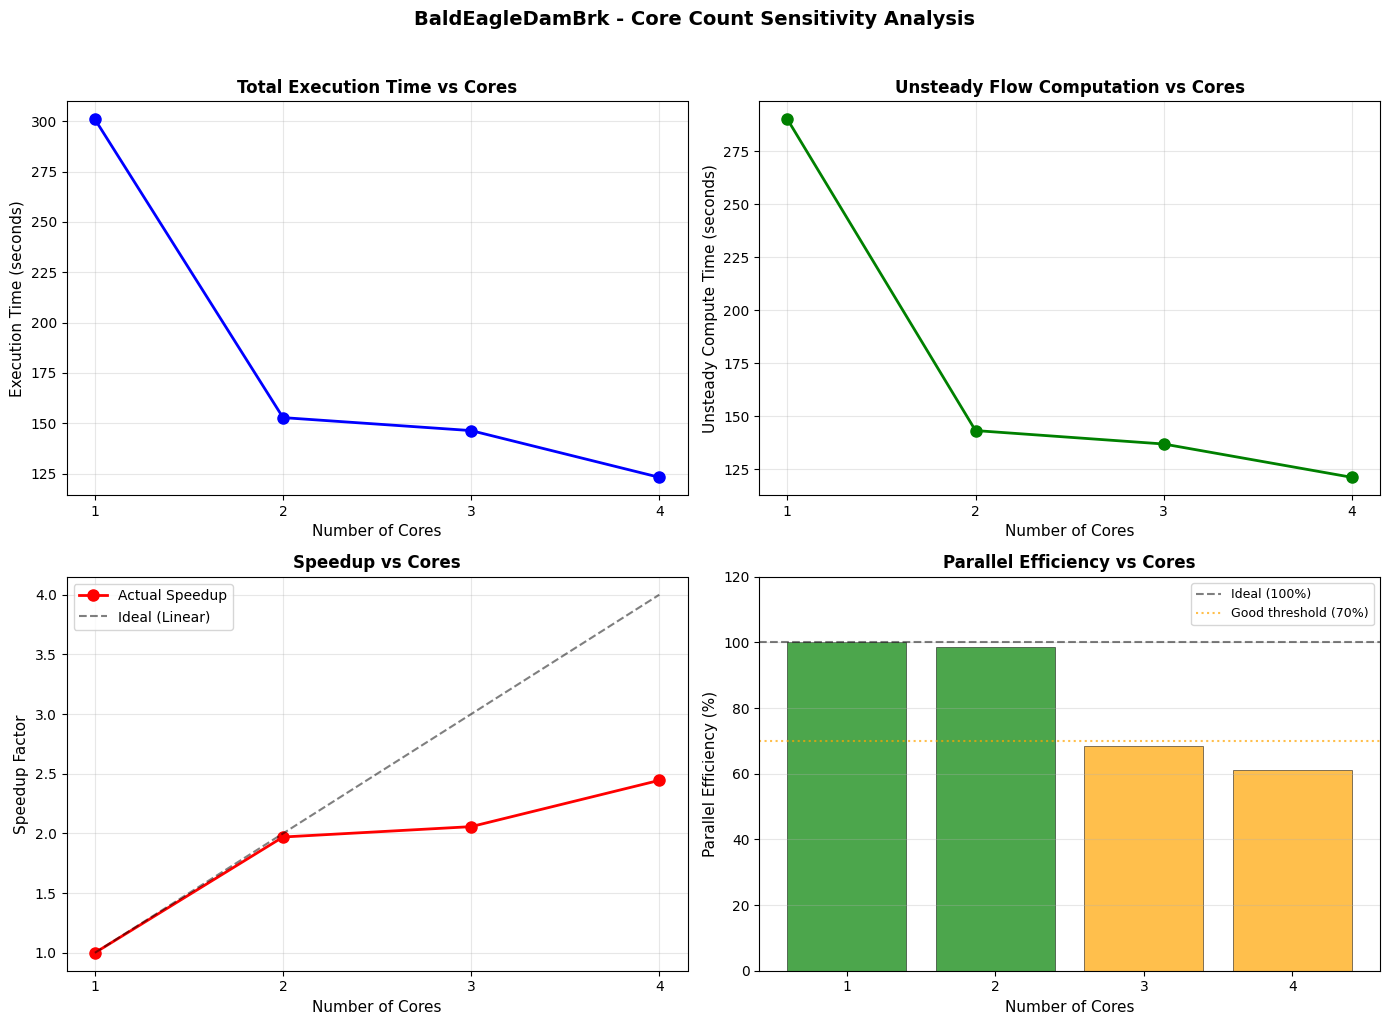


Figure saved to: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_700\outputs\core_sensitivity_analysis.png


In [ ]:
# ============================================================================
# PERFORMANCE METRICS CALCULATION
# ============================================================================

# Calculate speedup (baseline = 1-core time)
baseline_time = sensitivity_df['execution_time_s'].iloc[0]
sensitivity_df['speedup'] = baseline_time / sensitivity_df['execution_time_s']

# Calculate parallel efficiency (ideal = 100%)
sensitivity_df['efficiency_pct'] = (sensitivity_df['speedup'] / sensitivity_df['cores']) * 100

# Calculate unit runtime (normalized to 1-core time)
sensitivity_df['unit_runtime'] = sensitivity_df['execution_time_s'] / baseline_time

# Get project name for titles
project_name = ras.project_name

# ============================================================================
# MULTI-METRIC FIGURE (2x2 Grid)
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Total Execution Time
ax1 = axes[0, 0]
ax1.plot(sensitivity_df['cores'], sensitivity_df['execution_time_s'], 'b-o', 
         linewidth=2, markersize=8, label='Total Time')
ax1.set_xlabel("Number of Cores", fontsize=11)
ax1.set_ylabel("Execution Time (seconds)", fontsize=11)
ax1.set_title("Total Execution Time vs Cores", fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.xaxis.set_major_locator(plt.MultipleLocator(1))

# Plot 2: Unsteady Compute Time (Primary parallel portion)
ax2 = axes[0, 1]
ax2.plot(sensitivity_df['cores'], sensitivity_df['unsteady_time_s'], 'g-o', 
         linewidth=2, markersize=8, label='Unsteady Compute')
ax2.set_xlabel("Number of Cores", fontsize=11)
ax2.set_ylabel("Unsteady Compute Time (seconds)", fontsize=11)
ax2.set_title("Unsteady Flow Computation vs Cores", fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.xaxis.set_major_locator(plt.MultipleLocator(1))

# Plot 3: Speedup Factor
ax3 = axes[1, 0]
ax3.plot(sensitivity_df['cores'], sensitivity_df['speedup'], 'r-o', 
         linewidth=2, markersize=8, label='Actual Speedup')
ax3.plot(sensitivity_df['cores'], sensitivity_df['cores'], 'k--', 
         alpha=0.5, linewidth=1.5, label='Ideal (Linear)')
ax3.set_xlabel("Number of Cores", fontsize=11)
ax3.set_ylabel("Speedup Factor", fontsize=11)
ax3.set_title("Speedup vs Cores", fontsize=12, fontweight='bold')
ax3.legend(loc='upper left')
ax3.grid(True, alpha=0.3)
ax3.xaxis.set_major_locator(plt.MultipleLocator(1))

# Plot 4: Parallel Efficiency
ax4 = axes[1, 1]
colors = ['green' if e > 70 else 'orange' if e > 50 else 'red' 
          for e in sensitivity_df['efficiency_pct']]
ax4.bar(sensitivity_df['cores'], sensitivity_df['efficiency_pct'], 
        color=colors, alpha=0.7, edgecolor='black', linewidth=0.5)
ax4.axhline(y=100, color='k', linestyle='--', alpha=0.5, label='Ideal (100%)')
ax4.axhline(y=70, color='orange', linestyle=':', alpha=0.7, label='Good threshold (70%)')
ax4.set_xlabel("Number of Cores", fontsize=11)
ax4.set_ylabel("Parallel Efficiency (%)", fontsize=11)
ax4.set_title("Parallel Efficiency vs Cores", fontsize=12, fontweight='bold')
ax4.set_ylim(0, 120)
ax4.legend(loc='upper right', fontsize=9)
ax4.grid(True, alpha=0.3, axis='y')
ax4.xaxis.set_major_locator(plt.MultipleLocator(1))

plt.suptitle(f"{project_name} - Core Count Sensitivity Analysis", 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(outputs_dir / "core_sensitivity_analysis.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"\nFigure saved to: {outputs_dir / 'core_sensitivity_analysis.png'}")

## Summary and Recommendations

Final summary table with all metrics and optimal core count recommendation based on efficiency threshold.

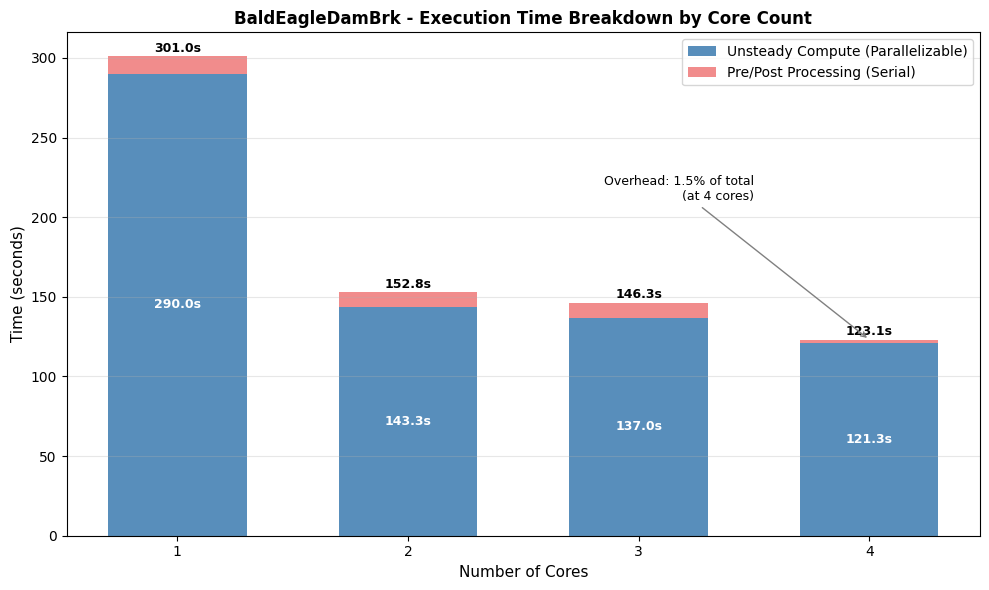


Figure saved to: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_700\outputs\time_breakdown.png


In [ ]:
# ============================================================================
# TIME BREAKDOWN STACKED BAR CHART
# ============================================================================
# Shows how total execution time is split between:
# - Unsteady compute (parallelizable - benefits from more cores)
# - Overhead (pre/post processing - mostly serial, minimal core benefit)

fig, ax = plt.subplots(figsize=(10, 6))

# Bar positioning
x = sensitivity_df['cores']
width = 0.6

# Create stacked bars
bars1 = ax.bar(x, sensitivity_df['unsteady_time_s'], width, 
               label='Unsteady Compute (Parallelizable)', color='steelblue', alpha=0.9)
bars2 = ax.bar(x, sensitivity_df['overhead_s'], width, 
               bottom=sensitivity_df['unsteady_time_s'],
               label='Pre/Post Processing (Serial)', color='lightcoral', alpha=0.9)

# Add value labels on bars
for i, (cores, total, unsteady, overhead) in enumerate(zip(
    sensitivity_df['cores'], 
    sensitivity_df['execution_time_s'],
    sensitivity_df['unsteady_time_s'],
    sensitivity_df['overhead_s'])):
    
    # Label for unsteady portion (center of bar)
    if unsteady > 5:  # Only label if bar is tall enough
        ax.text(cores, unsteady/2, f'{unsteady:.1f}s', 
                ha='center', va='center', fontsize=9, color='white', fontweight='bold')
    
    # Total label on top
    ax.text(cores, total + 1, f'{total:.1f}s', 
            ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xlabel("Number of Cores", fontsize=11)
ax.set_ylabel("Time (seconds)", fontsize=11)
ax.set_title(f"{project_name} - Execution Time Breakdown by Core Count", 
             fontsize=12, fontweight='bold')
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3, axis='y')
ax.xaxis.set_major_locator(plt.MultipleLocator(1))

# Add annotation explaining the breakdown
overhead_pct = (sensitivity_df['overhead_s'].iloc[-1] / sensitivity_df['execution_time_s'].iloc[-1]) * 100
ax.annotate(f'Overhead: {overhead_pct:.1f}% of total\n(at {NUM_WORKERS} cores)', 
            xy=(NUM_WORKERS, sensitivity_df['execution_time_s'].iloc[-1]),
            xytext=(NUM_WORKERS - 0.5, sensitivity_df['execution_time_s'].max() * 0.7),
            fontsize=9, ha='right',
            arrowprops=dict(arrowstyle='->', color='gray', lw=1))

plt.tight_layout()
plt.savefig(outputs_dir / "time_breakdown.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"\nFigure saved to: {outputs_dir / 'time_breakdown.png'}")

In [ ]:
# ============================================================================
# SUMMARY TABLE WITH ALL METRICS
# ============================================================================

# Create formatted summary table
summary_df = sensitivity_df[[
    'cores', 'execution_time_s', 'unsteady_time_s', 'overhead_s',
    'speedup', 'efficiency_pct', 'completed', 'vol_error_percent'
]].copy()

# Rename columns for readability
summary_df.columns = [
    'Cores', 'Total (s)', 'Unsteady (s)', 'Overhead (s)',
    'Speedup', 'Efficiency (%)', 'Completed', 'Vol Error (%)'
]

print("=" * 80)
print("CORE SENSITIVITY ANALYSIS - SUMMARY")
print("=" * 80)
print(f"\nProject: {project_name}")
print(f"Plan: {PLAN}")
print(f"Core range tested: 1 to {NUM_WORKERS}")
print("\n" + summary_df.to_string(index=False, float_format='%.2f'))

# ============================================================================
# OPTIMAL CORE RECOMMENDATION
# ============================================================================

print("\n" + "=" * 80)
print("RECOMMENDATIONS")
print("=" * 80)

# Find optimal core count (highest cores with efficiency > 70%)
efficient_cores = sensitivity_df[sensitivity_df['efficiency_pct'] > 70]['cores']
if len(efficient_cores) > 0:
    optimal_cores = efficient_cores.max()
else:
    optimal_cores = 1  # Fallback if all efficiencies are low

# Time savings calculation
time_at_1_core = sensitivity_df.loc[sensitivity_df['cores'] == 1, 'execution_time_s'].values[0]
time_at_optimal = sensitivity_df.loc[sensitivity_df['cores'] == optimal_cores, 'execution_time_s'].values[0]
time_savings_pct = ((time_at_1_core - time_at_optimal) / time_at_1_core) * 100

print(f"\n  Optimal Core Count: {optimal_cores}")
print(f"    - Maintains >70% parallel efficiency")
print(f"    - Time savings: {time_savings_pct:.1f}% vs single core")
print(f"    - Execution time: {time_at_optimal:.1f}s (vs {time_at_1_core:.1f}s at 1 core)")

# Additional insights
max_speedup = sensitivity_df['speedup'].max()
max_speedup_cores = sensitivity_df.loc[sensitivity_df['speedup'].idxmax(), 'cores']
print(f"\n  Maximum Speedup: {max_speedup:.2f}x (at {max_speedup_cores} cores)")

# Efficiency insights
avg_efficiency = sensitivity_df['efficiency_pct'].mean()
print(f"  Average Efficiency: {avg_efficiency:.1f}%")

# Save enhanced summary CSV
summary_csv_path = outputs_dir / "core_sensitivity_summary.csv"
summary_df.to_csv(summary_csv_path, index=False)
print(f"\n  Summary saved to: {summary_csv_path}")

CORE SENSITIVITY ANALYSIS - SUMMARY

Project: BaldEagleDamBrk
Plan: 03
Core range tested: 1 to 4

 Cores  Total (s)  Unsteady (s)  Overhead (s)  Speedup  Efficiency (%)  Completed  Vol Error (%)
     1     301.05        290.02         11.03     1.00          100.00       True           0.02
     2     152.80        143.31          9.48     1.97           98.51       True           0.02
     3     146.34        136.98          9.36     2.06           68.57       True           0.02
     4     123.12        121.28          1.84     2.45           61.13       True           0.02

RECOMMENDATIONS

  Optimal Core Count: 2
    - Maintains >70% parallel efficiency
    - Time savings: 49.2% vs single core
    - Execution time: 152.8s (vs 301.0s at 1 core)

  Maximum Speedup: 2.45x (at 4 cores)
  Average Efficiency: 82.1%

  Summary saved to: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_700\outputs\core_sensitivity_summary.csv
